<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/model_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install keras_visualizer librosa scipy tensorflow

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import files
import shutil
from tqdm.auto import tqdm
import librosa
from scipy.signal import butter, lfilter

In [3]:
!wget -q -O validation.zip https://www.dropbox.com/scl/fi/7iz9uk0fisb1i5m0xgn4n/validation.zip?rlkey=ef04n1whn56u05mod2fcm7h1y&dl=0
!unzip -q 'validation.zip'

In [ ]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.png'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [4]:
!wget -q -O final_model.h5 https://www.dropbox.com/scl/fi/1bogkhpbhlsi6mun2xh9p/final_model.h5?rlkey=2a5fgach18gq1h8tdcgwvykm8&dl=0

In [5]:
model = load_model("final_model.h5")

Showing the final model architecture

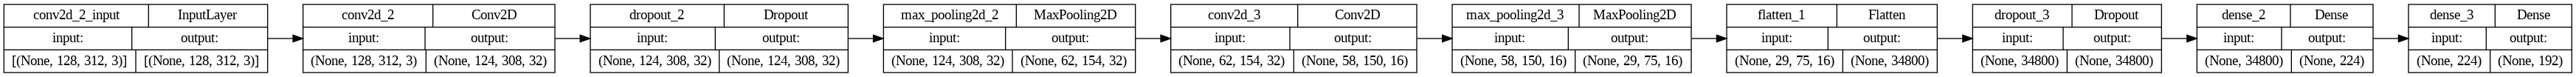

In [18]:
keras.utils.plot_model(model, rankdir='LR', to_file='model.png', show_shapes=True)

In [6]:
batch_size=128
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    'validation',
    target_size=(128, 312),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8276 images belonging to 192 classes.


Validate the model the validation set we created during training

In [8]:
num_batches = len(valid_generator)

# Make predictions on the validation data generator
predictions = model.predict(valid_generator, steps=num_batches)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_labels = valid_generator.classes

# Evaluate accuracy for predictions
accuracy = np.mean(np.equal(true_labels, predicted_labels))
print("Accuracy:", accuracy)

65/65 [==============================] - 157s 2s/step
Accuracy: 0.5169163847269213


We can see, that it produces the same accuracy as it produced on the test set, so in general, we can be satisfied with the model's performance.
Let's plot the confusion matrix.

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualize confusion matrix
plt.figure(figsize=(100, 100))
sns.heatmap(cm, annot=True,fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
!wget -q -O birdlabels.csv https://www.dropbox.com/scl/fi/e5071e7yznm56gqpsvc95/birdlabels.csv?rlkey=04vfmbj5e0d6yqc9acixt3bln&dl=0

In [23]:
birdlabels_df = pd.read_csv('birdlabels.csv')

In [25]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels, target_names=birdlabels_df['Bird'])
print(report)

              precision    recall  f1-score   support

     abethr1       0.00      0.00      0.00         6
     abhori1       0.32      0.58      0.41        62
     abythr1       0.26      0.36      0.30        14
     afbfly1       0.50      0.17      0.25         6
     afdfly1       0.20      0.25      0.22        12
     afecuc1       0.69      0.69      0.69        42
     affeag1       0.57      0.44      0.50         9
     afghor1       0.42      0.53      0.47        30
     afmdov1       0.33      0.30      0.32        10
     afpfly1       0.18      0.26      0.22        42
     afpwag1       0.37      0.38      0.37        39
     afrgos1       0.41      0.39      0.40        28
     afrgrp1       0.00      0.00      0.00         7
     afrjac1       0.33      0.33      0.33         9
     afrthr1       0.64      0.58      0.61        36
     amesun2       0.14      0.24      0.18        21
     bagwea1       0.00      0.00      0.00         8
      barswa       0.42    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
!wget -q -O testsample.ogg https://www.dropbox.com/scl/fi/67ew02uviyindzumfvhl1/soundscape_29201.ogg?rlkey=puuq3y9zoi78g5dsv5cyizocg&dl=0

And finally, the prediction for the testsample. We extract all the bird calls from the file, give a prediction on all of them and the concatenate the results by including the maximal value to every category from all the predictions in the final results.

In [33]:
# Define a highpass Butterworth filter
def butter_highpass(cutoff, fs, order=5):
    # Calculate Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize the cutoff frequency
    normal_cutoff = cutoff / nyquist
    # Create the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Apply a highpass Butterworth filter to the input data
def butter_highpass_filter(data, cutoff, fs, order=5):
     # Get filter coefficients
    b, a = butter_highpass(cutoff, fs, order=order)
    # Apply the filter to the data
    y = lfilter(b, a, data)
    return y

def get_intervals(spectrogram, duration, length, window_size):
    # Summing the frame energies for each column of the spectrogram
    frame_energies = np.sum(spectrogram, axis=0)
    # Threshold for the chirp
    threshold = 10 * np.median(frame_energies)
    # See which frames surpass the threshold energy
    indices = np.where(frame_energies > threshold)[0]

    # Concatenating the segments that are within a window size proximity to each other
    # 0.95 multiplication ensures that interval size won't exceed window size due to rounding errors whn converting to waveform index
    max_length = (0.95 * window_size) / duration * length
    intervals = []
    if len(indices) == 0:
        pass
    else:
        current_sequence_start = indices[0]
        current_sequence_end = indices[0]
        for index in indices[1:]:
            if index - current_sequence_start <= max_length:
                current_sequence_end = index + 1 if index < length - 1 else index
            else:
                intervals.append([current_sequence_start, current_sequence_end])
                current_sequence_start = index
                current_sequence_end = index
        intervals.append([current_sequence_start, current_sequence_end])
    return intervals

# Adjusting the start and end ndices in a way that th window 'shifts' around the chirp within a file, makes the data more diverse
def adjust_interval(interval_index, num_intervals, window_len, start, end):
    position_factor = interval_index / (num_intervals - 1) if num_intervals > 1 else 0
    adjusted_start = int(start + position_factor * (end - start) - position_factor * window_len)
    adjusted_end = adjusted_start + window_len
    return adjusted_start, adjusted_end

# Cutting the segments with the adjusted start and end indices
def cut_segments(y, sr, interval, window_len, noise_level, interval_index, num_intervals):
    # If no chirps werel located in the file (because it was too noisy)
    if not interval:
        return None
    # Converting time indices to indices in the waveform
    start = interval[0] * sr
    end = interval[1] * sr
    window_len *= sr
    chirp_len = end - start
    # If chirp indices were out of range return none (bad interval)
    if chirp_len > window_len:
        return None
    # If file is shorter than window size we pad it with artificial noise
    elif len(y) < window_len:
        noise = np.random.normal(scale=noise_level, size=(window_len - len(y)))
        final_sample = np.concatenate((y, noise))
    # Cutting out the windows
    else:
        adjusted_start, adjusted_end = adjust_interval(interval_index, num_intervals, window_len, start, end)
        final_sample = y[adjusted_start:adjusted_end]
        # If because the index conversions the final waveform is a few frames shoter than the window we pad it with artificial noise
        if len(final_sample) < window_len:
            noise = np.random.normal(scale=noise_level, size=(window_len - len(final_sample)))
            final_sample = np.concatenate((final_sample, noise))
    return final_sample

# Function for converting the samples to images
def return_image(y, sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=514) #Adjusting hop length so that image size is multiple of 8
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    min_db = melspec_db.min()
    max_db = melspec_db.max()
    # Rescaling to RGB scale
    scaled_melspec_db = (255 * (melspec_db - min_db) / (max_db - min_db))
    # Copying values to 3 channels so they work flawlessly with imagedatagenerators and pretrained models optimized for rgb images
    # But this way the information content does not change
    scaled_melspec_db_3channel = np.stack([scaled_melspec_db]*3, axis=-1)
    scaled_melspec_db_3channel /= 255.0

    return scaled_melspec_db_3channel


def return_spectograms_array(y, sr, window_len=5):
    y = butter_highpass_filter(y, 1000, sr, 6)
    # Cutoff order at 6 -> determines "smoothness" of cutoff
    y = butter_highpass_filter(y, 1000, sr, 6)
    # Creating the melspectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Duration in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    # Spectrogram length
    length = spectrogram.shape[1]
    # Noise level for padding shorter segments with noise
    noise_level = np.sqrt(np.mean(y**2))
    # Retrieving the indices of the chirp intervals (in spectragram indices)
    intervals = get_intervals(spectrogram, duration, length, window_len)
    spectrograms = []
    for i, interval in enumerate(intervals):
        # Converting the spectragam indices to time indices for cutting the samples and logging
        interval[0] = interval[0] / length * duration
        interval[1] = interval[1] / length * duration
        # Cutting the windows around the chirps
        final_sample = cut_segments(y, sr, interval, window_len, noise_level, i, len(intervals))  # Cutting the segments
        image = return_image(final_sample, sr)
        spectrograms.append(image)
    spectrograms_array = np.array(spectrograms)
    return spectrograms_array

In [34]:
# Load the spectrogram images
y, sr = librosa.load('testsample.ogg', sr=None)
spectrograms = return_spectograms_array(y, sr)

In [35]:
# Predict
predictions = model.predict(spectrograms)

3/3 [==============================] - 1s 313ms/step


In [42]:
# Extract maximal prediction for all the categories
max_indices = np.argmax(predictions, axis=0)
result_array = predictions[max_indices, np.arange(predictions.shape[1])]
result_array = result_array.reshape(1, -1)
prediction_df = pd.DataFrame({'Bird label':birdlabels_df['Bird'], 'Probability of presence': result_array.flatten()})
prediction_df

,Bird label,Probability of presence
0,abethr1,0.160409
1,abhori1,0.252639
2,abythr1,0.000411
3,afbfly1,0.001058
4,afdfly1,0.002377
...,...,...
187,yelbis1,0.000009
188,yertin1,0.000656
189,yespet1,0.004771
190,yetgre1,0.000183
